In [32]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))


In [3]:
tor_2019 = read_merged('tornados', 2019)

In [4]:
tor_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58403 entries, 0 to 58402
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            58403 non-null  int64  
 1   DATE                  58403 non-null  object 
 2   LAT_mean              58403 non-null  float64
 3   LON_mean              58403 non-null  float64
 4   AVGDV_max             58403 non-null  int64  
 5   LLDV_max              58403 non-null  int64  
 6   MXDV_max              58403 non-null  int64  
 7   MXDV_HEIGHT_max       58403 non-null  int64  
 8   DEPTH_max             58403 non-null  float64
 9   MAX_SHEAR_max         58403 non-null  int64  
 10  MAX_SHEAR_HEIGHT_max  58403 non-null  float64
 11  county                58403 non-null  object 
 12  state                 58403 non-null  object 
 13  power_outage          58403 non-null  bool   
dtypes: bool(1), float64(4), int64(6), object(3)
memory usage: 5.8+ MB


In [5]:
#del light_2019['#ZDAY']
del tor_2019['Unnamed: 0']

In [6]:
tor_2019['DATE'] = pd.to_datetime(tor_2019['DATE'])
tor_2019['Month'] = tor_2019['DATE'].dt.month

In [7]:
tor_2019.columns

Index(['DATE', 'LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max',
       'county', 'state', 'power_outage', 'Month'],
      dtype='object')

In [8]:
tor_2019['power_outage'].value_counts(normalize=True)

False    0.957297
True     0.042703
Name: power_outage, dtype: float64

### Let's try XGBOOST

In [9]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer


In [11]:
tor_train, tor_test = train_test_split(tor_2019.copy(), shuffle=True, test_size=0.2, stratify=tor_2019.power_outage)

In [12]:
xgb_clas1 = xgboost.XGBClassifier(learning_rate=.1,
                                   max_depth=3,
                                   n_estimators=200, objective='binary:logistic')

In [13]:
features = ['LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max', 'Month']

In [14]:
xgb_clas1.fit(tor_train[features], tor_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
prec = precision_score(xgb_clas1.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(xgb_clas1.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.13634085213032582
recall:  0.6522781774580336


In [35]:
pred = xgb_clas1.predict(light_train[features])
acc, prec, recall = accuracy_score(pred, light_train.power_outage), precision_score(pred, light_train.power_outage), recall_score(pred, light_train.power_outage)

In [19]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (1, 20,  1),
    'n_estimators': range(100, 480, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)


In [20]:
grid_search.fit(tor_train[features], tor_train['power_outage'])

Fitting 5 folds for each of 760 candidates, totalling 3800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3],
                         'max_depth': range(1, 20),
                         'n_estimators': range(100, 480, 40)},
             scoring='f1', verbose=True)

In [21]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [22]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 1, 100): 0.0,
 (0.01, 1, 140): 0.0,
 (0.01, 1, 180): 0.0,
 (0.01, 1, 220): 0.0,
 (0.01, 1, 260): 0.0,
 (0.01, 1, 300): 0.0,
 (0.01, 1, 340): 0.0,
 (0.01, 1, 380): 0.0,
 (0.01, 1, 420): 0.0,
 (0.01, 1, 460): 0.0,
 (0.01, 2, 100): 0.0,
 (0.01, 2, 140): 0.0,
 (0.01, 2, 180): 0.0,
 (0.01, 2, 220): 0.0,
 (0.01, 2, 260): 0.0,
 (0.01, 2, 300): 0.0,
 (0.01, 2, 340): 0.0,
 (0.01, 2, 380): 0.0,
 (0.01, 2, 420): 0.0,
 (0.01, 2, 460): 0.0,
 (0.01, 3, 100): 0.0,
 (0.01, 3, 140): 0.0,
 (0.01, 3, 180): 0.0,
 (0.01, 3, 220): 0.0,
 (0.01, 3, 260): 0.001,
 (0.01, 3, 300): 0.001,
 (0.01, 3, 340): 0.001,
 (0.01, 3, 380): 0.004889975550122249,
 (0.01, 3, 420): 0.005853658536585366,
 (0.01, 3, 460): 0.005853658536585366,
 (0.01, 4, 100): 0.0,
 (0.01, 4, 140): 0.004980087095693602,
 (0.01, 4, 180): 0.007942976992327426,
 (0.01, 4, 220): 0.007940618140506209,
 (0.01, 4, 260): 0.015640002385004285,
 (0.01, 4, 300): 0.02536535670282013,
 (0.01, 4, 340): 0.032059066638673306,
 (0.01, 4, 380): 0.033017920

In [23]:
best_param = pars[np.argmax(scores)]

In [24]:
best_param

(0.03, 17, 180)

In [25]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.03,
    max_depth=17,
    n_estimators=180) 

In [26]:
best_model.fit(tor_train[features], tor_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
prec = precision_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.6902255639097744
recall:  0.8883870967741936


In [145]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.6274321524233082
recall:  0.8734039185338914


In [29]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 4.652883052825928,
 'LON_mean': 4.585465431213379,
 'AVGDV_max': 1.047420859336853,
 'LLDV_max': 1.0794237852096558,
 'MXDV_max': 1.0022969245910645,
 'MXDV_HEIGHT_max': 0.9618530869483948,
 'DEPTH_max': 1.1762429475784302,
 'MAX_SHEAR_max': 1.2311267852783203,
 'MAX_SHEAR_HEIGHT_max': 1.1681315898895264,
 'Month': 8.831318855285645}

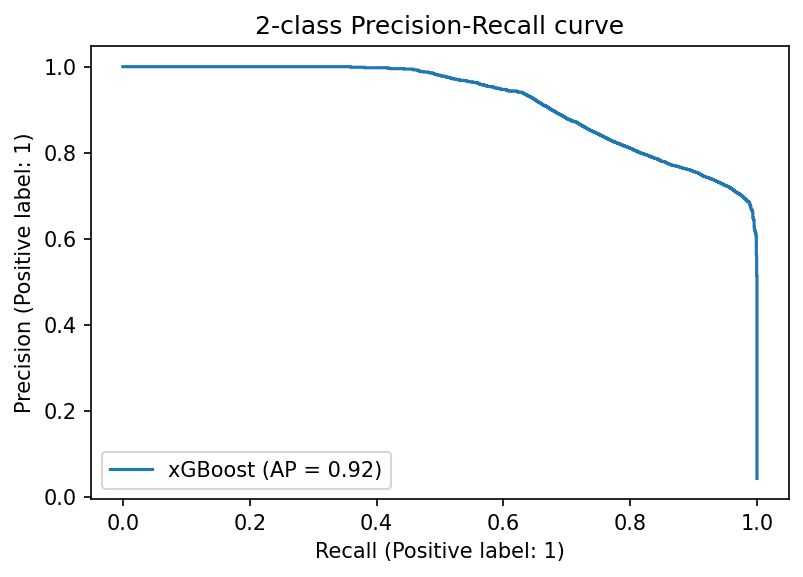

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_train[features], tor_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Work on the Balanced Dataset

In [48]:
outage = tor_train[tor_train['power_outage']==True]
no_outage = tor_train[tor_train['power_outage']==False]
no_outage= no_outage.sample(n=8*len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [35]:
balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 25142 to 53330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  7980 non-null   datetime64[ns]
 1   LAT_mean              7980 non-null   float64       
 2   LON_mean              7980 non-null   float64       
 3   AVGDV_max             7980 non-null   int64         
 4   LLDV_max              7980 non-null   int64         
 5   MXDV_max              7980 non-null   int64         
 6   MXDV_HEIGHT_max       7980 non-null   int64         
 7   DEPTH_max             7980 non-null   float64       
 8   MAX_SHEAR_max         7980 non-null   int64         
 9   MAX_SHEAR_HEIGHT_max  7980 non-null   float64       
 10  county                7980 non-null   object        
 11  state                 7980 non-null   object        
 12  power_outage          7980 non-null   bool          
 13  Month        

In [36]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (8, 20,  2),
    'n_estimators': range(100, 500, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)

In [37]:
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3],
                         'max_depth': range(8, 20, 2),
                         'n_estimators': range(100, 500, 40)},
             scoring='f1', verbose=True)

In [38]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [39]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 8, 100): 0.725908279934892,
 (0.01, 8, 140): 0.7461887392570804,
 (0.01, 8, 180): 0.7668915469796136,
 (0.01, 8, 220): 0.7717177004733282,
 (0.01, 8, 260): 0.7785149734368395,
 (0.01, 8, 300): 0.7822396935715996,
 (0.01, 8, 340): 0.7821008642326378,
 (0.01, 8, 380): 0.7827752328053984,
 (0.01, 8, 420): 0.7809322768885727,
 (0.01, 8, 460): 0.7815653129483878,
 (0.01, 10, 100): 0.7403129571907667,
 (0.01, 10, 140): 0.765148313856292,
 (0.01, 10, 180): 0.7782445990984772,
 (0.01, 10, 220): 0.7804861481484112,
 (0.01, 10, 260): 0.7825723959531389,
 (0.01, 10, 300): 0.7829051248569482,
 (0.01, 10, 340): 0.7824670502949119,
 (0.01, 10, 380): 0.7810053006987102,
 (0.01, 10, 420): 0.7814521471909465,
 (0.01, 10, 460): 0.7815415338235272,
 (0.01, 12, 100): 0.7350170018472596,
 (0.01, 12, 140): 0.7608502334150724,
 (0.01, 12, 180): 0.7676318924780636,
 (0.01, 12, 220): 0.7726478780856658,
 (0.01, 12, 260): 0.7743512923411969,
 (0.01, 12, 300): 0.7776178624737564,
 (0.01, 12, 340): 0.7759

In [41]:
best_param = pars[np.argmax(scores)]
best_param

(0.03, 10, 100)

In [49]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.03,
    max_depth=10,
    n_estimators=100) 

In [50]:
best_model.fit(balanced[features], balanced['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
prec = precision_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.7363408521303259
recall:  0.5248302965344765


In [53]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 12.50930404663086,
 'LON_mean': 11.72362232208252,
 'AVGDV_max': 2.1541082859039307,
 'LLDV_max': 1.9926567077636719,
 'MXDV_max': 1.8931102752685547,
 'MXDV_HEIGHT_max': 1.8448606729507446,
 'DEPTH_max': 2.5698893070220947,
 'MAX_SHEAR_max': 2.258812189102173,
 'MAX_SHEAR_HEIGHT_max': 1.939786672592163,
 'Month': 16.8094482421875}

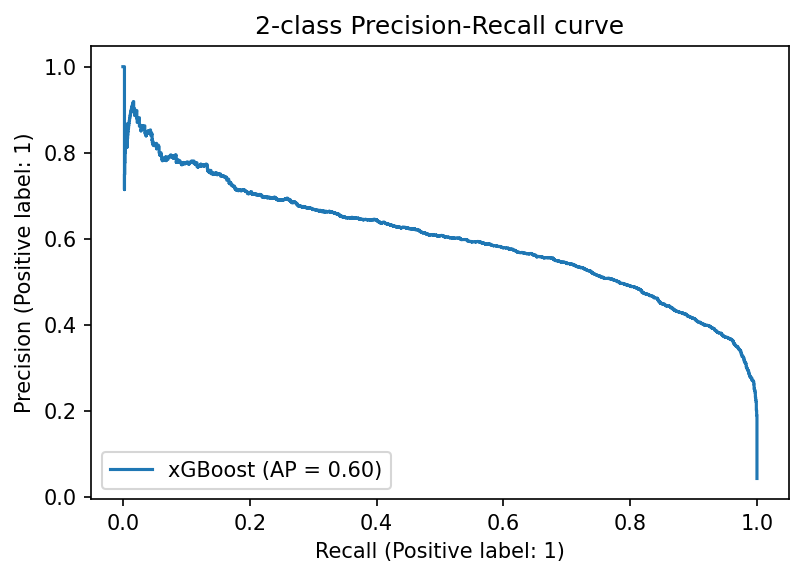

In [54]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_train[features], tor_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")